2025-01-27 21:44:54.732949: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-01-27 21:44:54.735785: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 21:44:54.739157: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 0, Loss: 384.86102294921875
Epoch 1000, Loss: 52.4617805480957
Epoch 2000, Loss: 38.4089241027832
Epoch 3000, Loss: 37.95973205566406
Epoch 4000, Loss: 37.3520393371582
Epoch 5000, Loss: 36.677574157714844
Epoch 6000, Loss: 36.18656539916992
Epoch 7000, Loss: 35.826290130615234
Epoch 8000, Loss: 35.40526580810547
Epoch 9000, Loss: 35.01527786254883
Epoch 9999, Loss: 34.80390167236328
Max absolute difference: 1.5524433237614903


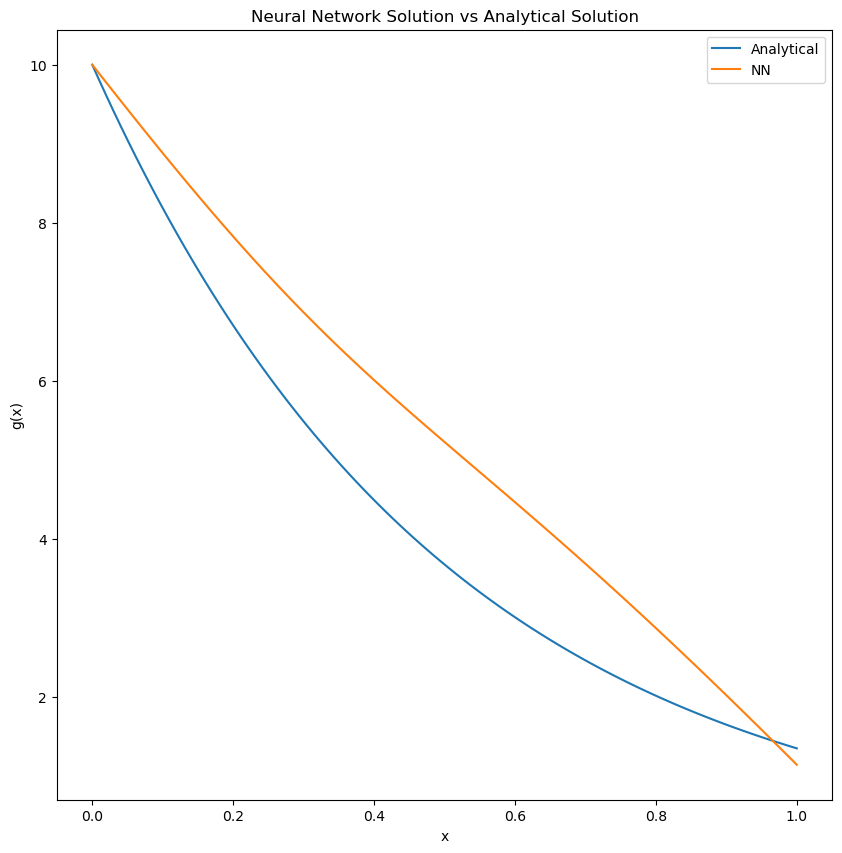

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt

# Define a custom layer for trial solution
class TrialSolution(Model):
    def __init__(self, hidden_units, g0=10):
        super(TrialSolution, self).__init__()
        self.hidden = Dense(hidden_units, activation="sigmoid", use_bias=True)
        self.output_layer = Dense(1, activation="linear", use_bias=True)
        self.g0 = g0

    def call(self, x):
        x = tf.expand_dims(x, axis=-1)  # Ensure input is 2D
        hidden_output = self.hidden(x)
        trial_output = self.g0 + x * self.output_layer(hidden_output)
        return trial_output

# Define the right-hand side of the ODE (e.g., -gamma * g_trial)
def ode_rhs(x, g_trial, gamma=2):
    return -gamma * g_trial

# Define the custom loss function
def loss_function(model, x, gamma=2):
    with tf.GradientTape() as tape:
        tape.watch(x)
        g_trial = model(x)
    
        # Compute derivative of g_trial w.r.t x
        d_g_trial = tape.gradient(g_trial, x)

    # Compute the ODE residual
    rhs = ode_rhs(x, g_trial, gamma)
    residual = d_g_trial - rhs

    return tf.reduce_mean(tf.square(residual))

# Analytical solution
def g_analytic(x, gamma=2, g0=10):
    return g0 * np.exp(-gamma * x)

# Training function
def train_model(model, x, num_epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(model, x)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 1000 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Main function
if __name__ == "__main__":
    # Define parameters
    N = 10
    x = tf.constant(np.linspace(0, 1, N), dtype=tf.float32)
    num_hidden_neurons = 10
    num_epochs = 10000
    learning_rate = 0.001

    # Initialize and train the model
    model = TrialSolution(hidden_units=num_hidden_neurons)
    train_model(model, x, num_epochs, learning_rate)

    # Evaluate the results
    x_eval = np.linspace(0, 1, 100)
    g_nn = model(tf.constant(x_eval, dtype=tf.float32)).numpy().flatten()
    g_exact = g_analytic(x_eval)

    print(f"Max absolute difference: {np.max(np.abs(g_nn - g_exact))}")

    # Plot the results
    plt.figure(figsize=(10, 10))
    plt.title("Neural Network Solution vs Analytical Solution")
    plt.plot(x_eval, g_exact, label="Analytical")
    plt.plot(x_eval, g_nn, label="NN")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("g(x)")
    plt.show()


Initial cost: 367.01
Final cost: 0.0666807
Max absolute difference: 0.0437499


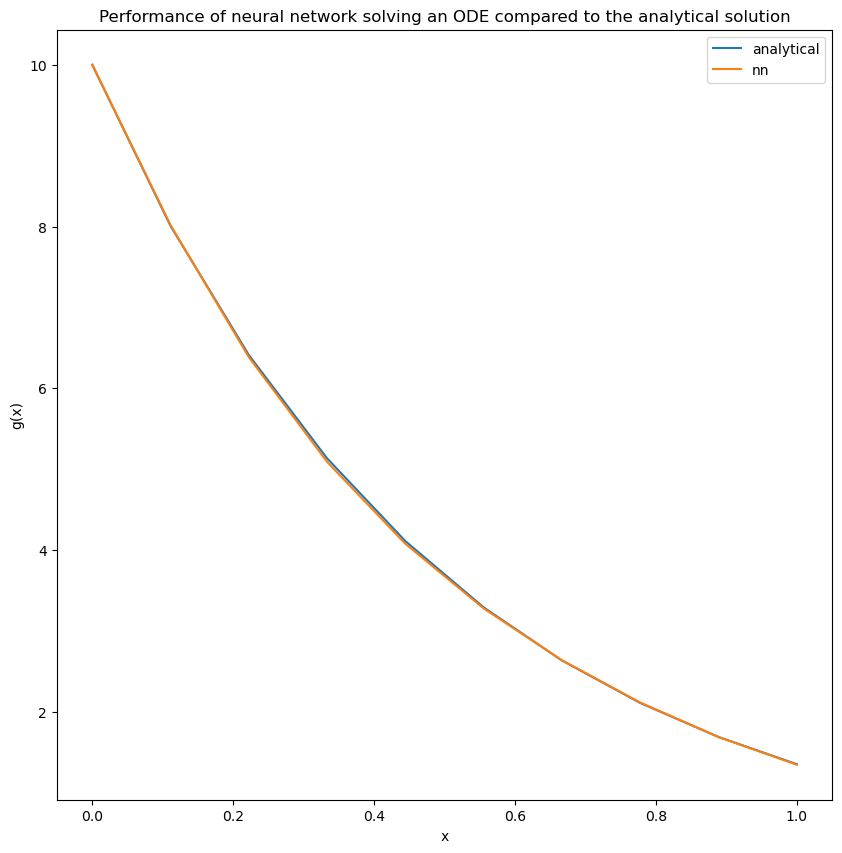

In [3]:
%matplotlib inline

import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Assuming one input, hidden, and output layer
def neural_network(params, x):

    # Find the weights (including and biases) for the hidden and output layer.
    # Assume that params is a list of parameters for each layer.
    # The biases are the first element for each array in params,
    # and the weights are the remaning elements in each array in params.

    w_hidden = params[0]
    w_output = params[1]

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    ## Hidden layer:

    # Add a row of ones to include bias
    x_input = np.concatenate((np.ones((1,num_values)), x_input ), axis = 0)

    z_hidden = np.matmul(w_hidden, x_input)
    x_hidden = sigmoid(z_hidden)

    ## Output layer:

    # Include bias:
    x_hidden = np.concatenate((np.ones((1,num_values)), x_hidden ), axis = 0)

    z_output = np.matmul(w_output, x_hidden)
    x_output = z_output

    return x_output

# The trial solution using the deep neural network:
def g_trial(x,params, g0 = 10):
    return g0 + x*neural_network(params,x)

# The right side of the ODE:
def g(x, g_trial, gamma = 2):
    return -gamma*g_trial

# The cost function:
def cost_function(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial(x,P)

    # Find the derivative w.r.t x of the neural network
    d_net_out = elementwise_grad(neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial,0)(x,P)

    # The right side of the ODE
    func = g(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

# Solve the exponential decay ODE using neural network with one input, hidden, and output layer
def solve_ode_neural_network(x, num_neurons_hidden, num_iter, lmb):
    ## Set up initial weights and biases

    # For the hidden layer
    p0 = npr.randn(num_neurons_hidden, 2 )

    # For the output layer
    p1 = npr.randn(1, num_neurons_hidden + 1 ) # +1 since bias is included

    P = [p0, p1]

    print('Initial cost: %g'%cost_function(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_grad = grad(cost_function,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of two arrays;
        # one for the gradient w.r.t P_hidden and
        # one for the gradient w.r.t P_output
        cost_grad =  cost_function_grad(P, x)

        P[0] = P[0] - lmb * cost_grad[0]
        P[1] = P[1] - lmb * cost_grad[1]

    print('Final cost: %g'%cost_function(P, x))

    return P

def g_analytic(x, gamma = 2, g0 = 10):
    return g0*np.exp(-gamma*x)

# Solve the given problem
if __name__ == '__main__':
    # Set seed such that the weight are initialized
    # with same weights and biases for every run.
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    N = 10
    x = np.linspace(0, 1, N)

    ## Set up the initial parameters
    num_hidden_neurons = 10
    num_iter = 10000
    lmb = 0.001

    # Use the network
    P = solve_ode_neural_network(x, num_hidden_neurons, num_iter, lmb)

    # Print the deviation from the trial solution and true solution
    res = g_trial(x,P)
    res_analytical = g_analytic(x)

    print('Max absolute difference: %g'%np.max(np.abs(res - res_analytical)))

    # Plot the results
    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Concatenate
import numpy as np
import matplotlib.pyplot as plt

# Define a custom neural network model in Keras
def create_model(num_neurons_hidden):
    model = Sequential([
        Dense(num_neurons_hidden, activation='sigmoid', input_shape=(1,), kernel_initializer='random_normal'),
        Dense(1, activation='linear', kernel_initializer='random_normal')
    ])
    return model

# Define the trial solution
def g_trial(x, model, g0=10):
    return g0 + x * model(x)

# The right side of the ODE
def g(x, g_trial, gamma=2):
    return -gamma * g_trial

# Custom loss function
def custom_loss(x, model):
    with tf.GradientTape() as tape1:
        tape1.watch(x)
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            g_t = g_trial(x, model)
        d_g_t = tape2.gradient(g_t, x)
    d2_g_t = tape1.gradient(d_g_t, x)
    func = g(x, g_t)
    return tf.reduce_mean((d2_g_t - func) ** 2)

# Training function
def train_model(model, x, num_iter, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    for i in range(num_iter):
        with tf.GradientTape() as tape:
            loss = custom_loss(x, model)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if i % 1000 == 0 or i == num_iter - 1:
            print(f"Iteration {i}, Loss: {loss.numpy()}")

# Analytical solution
def g_analytic(x, gamma=2, g0=10):
    return g0 * np.exp(-gamma * x)

if __name__ == '__main__':
    # Define problem parameters
    np.random.seed(15)
    tf.random.set_seed(15)

    N = 10
    x = np.linspace(0, 1, N).reshape(-1, 1).astype(np.float32)

    num_hidden_neurons = 10
    num_iter = 10000
    learning_rate = 0.001

    # Create and train the model
    model = create_model(num_hidden_neurons)
    train_model(model, x, num_iter, learning_rate)

    # Evaluate the results
    x_test = np.linspace(0, 1, 100).reshape(-1, 1).astype(np.float32)
    res = g_trial(x_test, model).numpy()
    res_analytical = g_analytic(x_test)

    print('Max absolute difference:', np.max(np.abs(res - res_analytical)))

    # Plot the results
    plt.figure(figsize=(10, 10))
    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x_test, res_analytical, label='Analytical')
    plt.plot(x_test, res, label='Neural Network')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()


ValueError: Passed in object of type <class 'numpy.ndarray'>, not tf.Tensor

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt

# Define a custom layer for trial solution
class TrialSolution(Model):
    def __init__(self, hidden_units, g0=10):
        super(TrialSolution, self).__init__()
        self.hidden = Dense(hidden_units, activation="sigmoid", use_bias=True,kernel_initializer='random_normal')
        self.output_layer = Dense(1, activation="linear", use_bias=True,kernel_initializer='random_normal')
        self.g0 = g0

    def call(self, x):
        x = tf.convert_to_tensor(x, dtype=tf.float32)  # Ensure input is a tensor
        x = tf.expand_dims(x, axis=-1)  # Ensure input is 2D
        hidden_output = self.hidden(x)
        trial_output = self.g0 + x * self.output_layer(hidden_output)
        return trial_output

# Define the right-hand side of the ODE (e.g., -gamma * g_trial)
def ode_rhs(x, g_trial, gamma=2):
    return -gamma * g_trial

# Define the custom loss function
def loss_function(model, x, gamma=2):
    with tf.GradientTape() as tape:
        tape.watch(x)
        g_trial = model(x)
    
        # Compute derivative of g_trial w.r.t x
        d_g_trial = tape.gradient(g_trial, x)

    # Compute the ODE residual
    rhs = ode_rhs(x, g_trial, gamma)
    residual = d_g_trial - rhs

    return tf.reduce_mean(tf.square(residual))

# Analytical solution
def g_analytic(x, gamma=2, g0=10):
    return g0 * np.exp(-gamma * x)

# Training function
def train_model(model, x, num_epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    for epoch in range(num_epochs):
        with tf.GradientTape() as tape:
            loss = loss_function(model, x)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 1000 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Main function
if __name__ == "__main__":
    # Define parameters
    N = 10
    x = tf.constant(np.linspace(0, 1, N), dtype=tf.float32)  # Convert to tensor
    num_hidden_neurons = 10
    num_epochs = 10000
    learning_rate = 0.001

    # Initialize and train the model
    model = TrialSolution(hidden_units=num_hidden_neurons)
    train_model(model, x, num_epochs, learning_rate)

    # Evaluate the results
    x_eval = np.linspace(0, 1, 100)
    g_nn = model(tf.constant(x_eval, dtype=tf.float32)).numpy().flatten()
    g_exact = g_analytic(x_eval)

    print(f"Max absolute difference: {np.max(np.abs(g_nn - g_exact))}")

    # Plot the results
    plt.figure(figsize=(10, 10))
    plt.title("Neural Network Solution vs Analytical Solution")
    plt.plot(x_eval, g_exact, label="Analytical")
    plt.plot(x_eval, g_nn, label="NN")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("g(x)")
    plt.show()


Epoch 0, Loss: 422.3019104003906
Epoch 1000, Loss: 61.35087966918945
Epoch 2000, Loss: 38.3143424987793
Epoch 3000, Loss: 37.930030822753906
Epoch 4000, Loss: 37.413978576660156
Epoch 5000, Loss: 36.78786849975586
